Autores: 
- Fernando Basso Gresele
- Hyan Schubert
- Norton Martin Reichert Trennepohl

## Bibliotecas:

In [75]:
# Bibliotecas básicas
import numpy as np
import math
import matplotlib 

# Bibliotecas gráficas
import matplotlib.pyplot as plt
# Configurações dos gráficos
matplotlib.rc('font', family = 'Arial')
matplotlib.rc('font', size = 14)

# Para mostrar apenas 3 casas decimais
np.set_printoptions(precision=3)

## Constantes e dados de entrada:

In [76]:
# Direções: informar aqui a direção de cada lâmina (em graus), de CIMA para BAIXO em relação ao laminado:
direc_deg = [45,0,0,45]

# Conversão para radianos
direc = np.radians(direc_deg)
n = len(direc)

#Vetor de carregamentos (elementos não-nulos estão em unidades de N/m)
# Informar aqui os esforços, obedecendo a convenção:
#carreg = [[Nx],[Ny],[Nxy],[Mx],[My],[Mxy]]

carreg = [[1000*1000],[200*1000],[0],[0],[0],[0]] #N/m

#Espessura de cada lâmina (esp): informar 
esp = 5E-3 #m
#esp = float(input('Espessura (em m)'))

#Espessura do laminado
h = n*esp #m

# Dados do material: informar aqui:
E11 = 19.76E9 #Pa
E22 = 1.97E9 #Pa
nu12 = 0.35
G12 = 0.7E9 #Pa

#Relação entre coeficientes de Poisson
nu21 = (E22*nu12)/E11

# Informações sobre cirtério de falha (todas em MPa)
XT = 1447E6
XC = -1447E6
YT = 51.7E6
YC = -206E6
S12 = 93E6

## Matriz de rigidez reduzida transformada no sistema global de coordenadas:

In [77]:
Q11 = E11/(1-nu12*nu21)
Q22 = E22/(1-nu12*nu21)
Q66 = G12
Q12 = (nu12*E22)/(1-nu12*nu21)
Q21 = Q12

Q = np.array([[Q11, Q12, 0],[Q21, Q22, 0], [0, 0, Q66]])

cos = np.cos(direc)
sin = np.sin(direc)

# Inicialização dos vetores:
T = [[0 for _ in range(1)] for _ in range(n)]
T_inv = [[0 for _ in range(1)] for _ in range(n)]
Q_dash = [[0 for _ in range(1)] for _ in range(n)]
Reuter = [[1,0,0],[0,1,0],[0,0,2]] # Matriz de Reuter

# Cálculo da matriz Q_dash para cada uma das lâminas 
for i in range(n):
    T[i] = np.array([[cos[i]**2, sin[i]**2, 2*sin[i]*cos[i]],[sin[i]**2, cos[i]**2, -2*sin[i]*cos[i]],[-sin[i]*cos[i], sin[i]*cos[i], cos[i]**2-sin[i]**2]])
    T_inv[i] = np.linalg.inv(T[i])
    Q_dash[i] = T_inv[i]@Q@Reuter@T[i]@np.linalg.inv(Reuter)


## Matriz "ABBD":

In [78]:
# Matriz A: rigidez à tração e compressão
# Inicialização
A_local = [[0 for _ in range(1)] for _ in range(n)]
B_local = [[0 for _ in range(1)] for _ in range(n)]
D_local = [[0 for _ in range(1)] for _ in range(n)]
A_global = 0
B_global = 0
D_global = 0

for i in range(n):
    A_local[i] = Q_dash[i]*(((((n/2)-(i+1))/n)*-h) - (((n/2 - i)/n)*-h))
    #A_local[i] = Q_dash[i]*(h/n) # retorna os mesmos resultados, significa que está ok
    A_global = A_global + A_local[i]
    B_local[i] = 0.5*Q_dash[i]*(((((n/2)-(i+1))/n)*-h)**2 - (((n/2 - i)/n)*-h)**2)
    B_global = B_global + B_local[i]
    D_local[i] = (1/3)*Q_dash[i]*(((((n/2)-(i+1))/n)*-h)**3 - (((n/2 - i)/n)*-h)**3)
    D_global = D_global + D_local[i]

# Combinando as matrizes em uma só   
linha1 = np.vstack((A_global,B_global))
linha2 = np.vstack((B_global,D_global))
ABBD = np.hstack((linha1,linha2))
print("Matriz ABBD:")
print(ABBD)

Matriz ABBD:
[[ 2.655e+08  5.847e+07  4.502e+07 -2.910e-11  0.000e+00  0.000e+00]
 [ 5.847e+07  8.543e+07  4.502e+07  0.000e+00 -2.910e-11  0.000e+00]
 [ 4.502e+07  4.502e+07  5.851e+07  0.000e+00  0.000e+00  0.000e+00]
 [-2.910e-11  0.000e+00  0.000e+00  5.487e+03  3.062e+03  2.626e+03]
 [ 0.000e+00 -2.910e-11  0.000e+00  3.062e+03  3.986e+03  2.626e+03]
 [ 0.000e+00  0.000e+00  0.000e+00  2.626e+03  2.626e+03  3.063e+03]]


## Deformações no plano médio e curvatura em relação ao sistema global:

In [79]:
# Inicialização do vetor
def_curv = [[0],[0],[0],[0],[0],[0]]

def_curv = np.linalg.inv(ABBD)@carreg

epsilon_0_global = np.vstack((def_curv[0],def_curv[1],def_curv[2]))
K_global = np.vstack((def_curv[3],def_curv[4],def_curv[5]))

print(def_curv)


[[ 4.125e-03]
 [ 2.004e-03]
 [-4.716e-03]
 [ 3.249e-17]
 [ 1.847e-17]
 [-4.370e-17]]


Percebe-se que os valores de curvatura são muito baixos (podem ser considerados como nulos), o que já era esperado pois não é realizado momento sobre a estrutura. Isso indica que os resultados são condizentes.

## Tensões e deformações em cada lâmina:

In [80]:
# Tensões e deformações em cada lâmina (coordenadas z referenciadas no plano médio de cada lâmina)
sigma_global = [[0 for _ in range(1)] for _ in range(n)]
sigma_local = [[0 for _ in range(1)] for _ in range(n)]
z = [[0 for _ in range(1)] for _ in range(n)]
epsilon_global = [[0 for _ in range(1)] for _ in range(n)]
epsilon_local = [[0 for _ in range(1)] for _ in range(n)]
y = [[0 for _ in range(1)] for _ in range(n)]

for i in range(n):
    z[i] = 0.5*(((((n/2)-(i+1))/n)*-h) + (((n/2 - i)/n)*-h))
    sigma_global[i] = (Q_dash[i]@(epsilon_0_global + (z[i]*K_global)))
    print("==============================")
    print("Resultados lâmina %d:" %(i+1))
    print("Tensão na lâmina no sistema global de coordenadas (MPa): ")
    print(sigma_global[i]*10**-6)
    sigma_local[i] = T[i]@sigma_global[i]
    print("Tensão na lâmina no sistema local de coordenadas (MPa):")
    print(sigma_local[i]*10**-6)
    epsilon_global[i] = epsilon_0_global + z[i]*K_global
    print("Deformação no plano médio da lâmina no sistema global de coordenadas:")
    print(epsilon_global[i])
    epsilon_local[i] = T[i]@epsilon_global[i]
    print("Deformação no plano médio da lâmina no sistema local de coordenadas:")
    print(epsilon_local[i])   

Resultados lâmina 1:
Tensão na lâmina no sistema global de coordenadas (MPa): 
[[16.093]
 [13.124]
 [ 3.301]]
Tensão na lâmina no sistema local de coordenadas (MPa):
[[17.91 ]
 [11.307]
 [-1.484]]
Deformação no plano médio da lâmina no sistema global de coordenadas:
[[ 0.004]
 [ 0.002]
 [-0.005]]
Deformação no plano médio da lâmina no sistema local de coordenadas:
[[-0.002]
 [ 0.008]
 [-0.001]]
Resultados lâmina 2:
Tensão na lâmina no sistema global de coordenadas (MPa): 
[[83.907]
 [ 6.876]
 [-3.301]]
Tensão na lâmina no sistema local de coordenadas (MPa):
[[83.907]
 [ 6.876]
 [-3.301]]
Deformação no plano médio da lâmina no sistema global de coordenadas:
[[ 0.004]
 [ 0.002]
 [-0.005]]
Deformação no plano médio da lâmina no sistema local de coordenadas:
[[ 0.004]
 [ 0.002]
 [-0.005]]
Resultados lâmina 3:
Tensão na lâmina no sistema global de coordenadas (MPa): 
[[83.907]
 [ 6.876]
 [-3.301]]
Tensão na lâmina no sistema local de coordenadas (MPa):
[[83.907]
 [ 6.876]
 [-3.301]]
Deforma

## Análise de falhas: Máxima tração

In [81]:
CS_1 = [[0 for _ in range(1)] for _ in range(n)]
CS_2 = [[0 for _ in range(1)] for _ in range(n)]
CS_12 = [[0 for _ in range(1)] for _ in range(n)]

for i in range(n):
    if sigma_local[i][0,0] > 0:
        CS_1[i] = XT/sigma_local[i][0,0]
    else:
        CS_1[i] = (XC)/sigma_local[i][0,0]

    if sigma_local[i][1,0] > 0:
        CS_2[i] = YT/sigma_local[i][1,0] 
    else:
        CS_2[i] = (YC)/sigma_local[i][1,0] 

    if sigma_local[i][2,0] > 0:
        CS_12[i] = S12/abs(sigma_local[i][2,0])
    else:
        CS_12[i] = S12/abs(sigma_local[i][2,0])
   
CS = min([min(CS_1),min(CS_2),min(CS_12)])

# resultados:
print("Margem de segurança pelo critério da máxima tensão: %.3f " %CS)

Margem de segurança pelo critério da máxima tensão: 4.572 


## Tsai-Hill

In [82]:
FS_TH = [[0 for _ in range(1)] for _ in range(n)]
MS_TH = [[0 for _ in range(1)] for _ in range(n)]

for i in range(n):
    if sigma_local[i][0,0] > 0 and sigma_local[i][1,0] > 0:
        FS_TH[i] = np.sqrt((sigma_local[i][0,0]/XT)**2 + (sigma_local[i][1,0]/YT)**2 - (sigma_local[i][1,0]*sigma_local[i][0,0]/(XT**2)+(sigma_local[i][2,0]/S12)**2))
        MS_TH[i] = 1/FS_TH[i]
    elif sigma_local[i][0,0] < 0 and sigma_local[i][1,0] > 0:
        FS_TH[i] = np.sqrt((sigma_local[i][0,0]/XC)**2 + (sigma_local[i][1,0]/YT)**2 - (sigma_local[i][1,0]*sigma_local[i][0,0]/(XC**2)+(sigma_local[i][2,0]/S12)**2))
        MS_TH[i] = 1/FS_TH[i] 
    elif sigma_local[i][0,0] < 0 and sigma_local[i][1,0] < 0:
        FS_TH[i] = np.sqrt((sigma_local[i][0,0]/XC)**2 + (sigma_local[i][1,0]/YC)**2 - (sigma_local[i][1,0]*sigma_local[i][0,0]/(XC**2)+(sigma_local[i][2,0]/S12)**2))
        MS_TH[i] = 1/FS_TH[i]
    elif sigma_local[i][0,0] > 0 and sigma_local[i][1,0] < 0:
        FS_TH[i] = np.sqrt((sigma_local[i][0,0]/XT)**2 + (sigma_local[i][1,0]/YC)**2 - (sigma_local[i][1,0]*sigma_local[i][0,0]/(XT**2)+(sigma_local[i][2,0]/S12)**2))
        MS_TH[i] = 1/FS_TH[i]   
   

print("Margem de segurança pelo critério de Tsai-Hill: %.3f " %(min(MS_TH)))


Margem de segurança pelo critério de Tsai-Hill: 4.582 


## Tsai-Wu

In [83]:
import math
F1 = 1/XT + 1/XC
F2 = 1/YT + 1/YC
F11 = -1/(XT*XC)
F22 = -1/(YT*YC)
F66 = (1/S12)**2
F12 = -0.5*np.sqrt(F11*F22)

A = [[0 for _ in range(1)] for _ in range(n)]
B = [[0 for _ in range(1)] for _ in range(n)]
Sf_pos = [[0 for _ in range(1)] for _ in range(n)]
Sf_neg = [[0 for _ in range(1)] for _ in range(n)]
Sf = [[0 for _ in range(1)] for _ in range(n)]

for i in range(n):
    A[i] = F11*sigma_local[i][0,0]**2 + F22*sigma_local[i][1,0]**2 + F66*sigma_local[i][2,0]**2 + 2*F12*sigma_local[i][0,0]*sigma_local[i][1,0]
    B[i] = F1*sigma_local[i][0,0] + F2*sigma_local[i][1,0]
    Sf_pos[i] = (-B[i] + np.sqrt(B[i]**2 + 4*A[i]))/(2*A[i])
    Sf_neg[i] = abs((-B[i] - np.sqrt(B[i]**2 + 4*A[i]))/(2*A[i]))

    Sf[i] = min(Sf_pos[i],Sf_neg[i])

print(Sf)

[4.646916924795244, 7.275996124113205, 7.275996124113205, 4.646916924795244]


## Curvas de falha

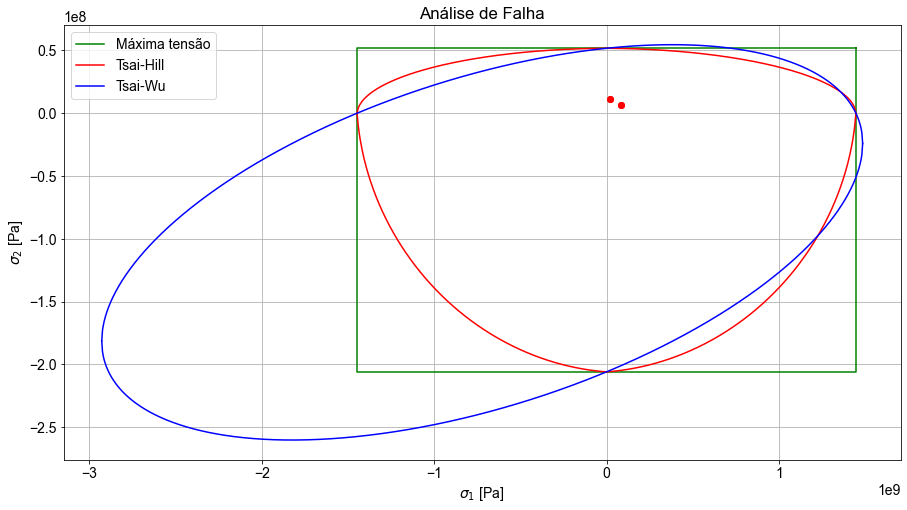

In [84]:
# Função para construção dos gráficos
def grafalha(XT,XC,YT,YC,S12,sigma_1_c,sigma_1_t,tau12,sigma_2):
    for k in range(249):
        sigma_2[k]     = (YT*np.sqrt(-4*XT**4*tau12**2+(S12**2*YT**2-4*S12**2*XT**2)*sigma_1_t[k]**2+4*S12**2*XT**4)-S12*YT**2*sigma_1_t[k])/(2*S12*XT**2)
        sigma_2[k+250] = (YT*np.sqrt(-4*XC**4*tau12**2+(S12**2*YT**2-4*S12**2*XC**2)*sigma_1_c[k]**2+4*S12**2*XC**4)+S12*YT**2*sigma_1_c[k])/(2*S12*XC**2)
        sigma_2[k+500] = (YC*np.sqrt(-4*XC**4*tau12**2+(S12**2*YC**2-4*S12**2*XC**2)*sigma_1_c[k]**2+4*S12**2*XC**4)-S12*YC**2*sigma_1_c[k])/(2*S12*XC**2)
        sigma_2[k+750] = (YC*np.sqrt(-4*XT**4*tau12**2+(S12**2*YC**2-4*S12**2*XT**2)*sigma_1_t[k]**2+4*S12**2*XT**4)+S12*YC**2*sigma_1_t[k])/(2*S12*XT**2)
    
    x_inter1 = -(2*(YC*YT*(S12**2*XC*XT*YC**2 + S12**2*XC*XT*YT**2 + S12**2*XC**2*YC*YT + S12**2*XT**2*YC*YT + S12**2*XC*XT*YC*YT + 3*XC*XT*YC*YT*tau12**2 - S12**2*XC*XT**2*YC*YT**2*(1/(XC*XT*YC*YT))**(1/2) - S12**2*XC*XT**2*YC**2*YT*(1/(XC*XT*YC*YT))**(1/2) - S12**2*XC**2*XT*YC*YT**2*(1/(XC*XT*YC*YT))**(1/2) - S12**2*XC**2*XT*YC**2*YT*(1/(XC*XT*YC*YT))**(1/2)))**(1/2) - 2*S12*XC*YC*YT - 2*S12*XT*YC*YT + S12*XC*XT*YC*YT**2*(1/(XC*XT*YC*YT))**(1/2) + S12*XC*XT*YC**2*YT*(1/(XC*XT*YC*YT))**(1/2))/(3*S12*YC*YT)
    x_inter2 = (2*(YC*YT*(S12**2*XC*XT*YC**2 + S12**2*XC*XT*YT**2 + S12**2*XC**2*YC*YT + S12**2*XT**2*YC*YT + S12**2*XC*XT*YC*YT + 3*XC*XT*YC*YT*tau12**2 - S12**2*XC*XT**2*YC*YT**2*(1/(XC*XT*YC*YT))**(1/2) - S12**2*XC*XT**2*YC**2*YT*(1/(XC*XT*YC*YT))**(1/2) - S12**2*XC**2*XT*YC*YT**2*(1/(XC*XT*YC*YT))**(1/2) - S12**2*XC**2*XT*YC**2*YT*(1/(XC*XT*YC*YT))**(1/2)))**(1/2) + 2*S12*XC*YC*YT + 2*S12*XT*YC*YT - S12*XC*XT*YC*YT**2*(1/(XC*XT*YC*YT))**(1/2) - S12*XC*XT*YC**2*YT*(1/(XC*XT*YC*YT))**(1/2))/(3*S12*YC*YT)
    
    sig1 = np.linspace(x_inter1,x_inter2, 1000)
    sig2 = np.linspace(0, 0, 1000)
    sig3 = np.linspace(0, 0, 1000)

    for k in range(1000):
        sig2[k] = (np.sqrt(4*XC**2*XT**2*YC*YT*tau12**2-3*S12**2*XC*XT*YC*YT*sig1[k]**2+(((4*S12**2*XC*XT**2+4*S12**2*XC**2*XT)*YC-2*S12**2*XC**2*XT**2*YC**2*np.sqrt(1/(XC*XT*YC*YT)))*YT-2*S12**2*XC**2*XT**2*YC*np.sqrt(1/(XC*XT*YC*YT))*YT**2)*sig1[k]+S12**2*XC**2*XT**2*YT**2-2*S12**2*XC**2*XT**2*YC*YT+S12**2*XC**2*XT**2*YC**2)-S12*XC*XT*YC*np.sqrt(1/(XC*XT*YC*YT))*YT*sig1[k]+S12*XC*XT*YT+S12*XC*XT*YC)/(2*S12*XC*XT)
        sig3[k] = -(np.sqrt(4*XC**2*XT**2*YC*YT*tau12**2-3*S12**2*XC*XT*YC*YT*sig1[k]**2+(((4*S12**2*XC*XT**2+4*S12**2*XC**2*XT)*YC-2*S12**2*XC**2*XT**2*YC**2*np.sqrt(1/(XC*XT*YC*YT)))*YT-2*S12**2*XC**2*XT**2*YC*np.sqrt(1/(XC*XT*YC*YT))*YT**2)*sig1[k]+S12**2*XC**2*XT**2*YT**2-2*S12**2*XC**2*XT**2*YC*YT+S12**2*XC**2*XT**2*YC**2)+S12*XC*XT*YC*np.sqrt(1/(XC*XT*YC*YT))*YT*sig1[k]-S12*XC*XT*YT-S12*XC*XT*YC)/(2*S12*XC*XT)
    
    # Tamanho da figura
    plt.figure(figsize=(15,8))

    # Curva do critério da máxima tensão
    plt.plot([XT,XC,XC,XT,XT],[YT,YT,YC,YC,YT],'g',label = 'Máxima tensão')

    # Curvas de Tsai-hill
    plt.plot(sigma_1_t,sigma_2[0:249],'r',label = 'Tsai-Hill') #Tsai-Hill 1º Quadrante
    plt.plot(sigma_1_c,sigma_2[250:499],'r') #Tsai-Hill 2º Quadrante
    plt.plot(sigma_1_c,sigma_2[500:749],'r') #Tsai-Hill 3º Quadrante
    plt.plot(sigma_1_t,sigma_2[750:999],'r') #Tsai-Hill 4º Quadrante

    # Curvas de Tsai-Wu
    plt.plot(sig1,sig2,'b',label = 'Tsai-Wu') #Tsai-Wu Positivo
    plt.plot(sig1,sig3,'b') #Tsai-Wu Negativo

    for i in range(n):
        plt.plot(sigma_local[i][0,0],sigma_local[i][1,0],'ro')
   
    plt.title('Análise de Falha')
    plt.xlabel("${\sigma_1}$ [Pa]")
    plt.ylabel("${\sigma_2}$ [Pa]")
    plt.grid()
    plt.legend()

#Tensão genérica
sigma_1_c = np.linspace(XC, 0, 249)
sigma_1_t = np.linspace(0, XT, 249)
tau12 = 0
sigma_2 = np.linspace(0, 0, 1000)

fig0 = grafalha(XT,XC,YT,YC,S12,sigma_1_c,sigma_1_t,tau12,sigma_2)


## Distribuição de deformações ao longo da lâmina

[[-0.01   -0.005  -0.      0.005 ]
 [-0.0075 -0.0025  0.0025  0.0075]
 [-0.005  -0.      0.005   0.01  ]]


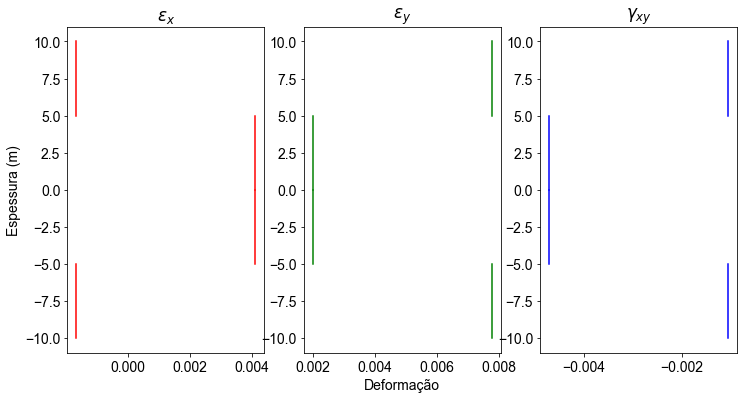

In [85]:
# Tensões e deformações em cada lâmina (coordenadas z referenciadas no plano médio de cada lâmina)
np.set_printoptions(precision=6)
z = np.array(np.zeros([3,n]))
epsilon_graph = np.array(np.zeros([3,n*3]))
sigma_graph = np.array(np.zeros([3,n*3]))

for i in range(n):
    z[0,i] = (((n/2 - i)/n)*-h)
    z[1,i] = 0.5*(((((n/2)-(i+1))/n)*-h) + (((n/2 - i)/n)*-h))
    z[2,i] = ((((n/2)-(i+1))/n)*-h)

    mat_0 = T[i]@(np.array(epsilon_0_global) + z[0,i]*np.array(K_global))
    mat_1 = T[i]@(np.array(epsilon_0_global) + z[1,i]*np.array(K_global))
    mat_2 = T[i]@(np.array(epsilon_0_global) + z[2,i]*np.array(K_global))
    
    epsilon_graph[0,i] = mat_0[0,0]
    epsilon_graph[1,i] = mat_0[1,0]
    epsilon_graph[2,i] = mat_0[2,0]
    epsilon_graph[0,i+n] = mat_1[0,0]
    epsilon_graph[1,i+n] = mat_1[1,0]
    epsilon_graph[2,i+n] = mat_1[2,0]
    epsilon_graph[0,i+2*n] = mat_2[0,0]
    epsilon_graph[1,i+2*n] = mat_2[1,0]
    epsilon_graph[2,i+2*n] = mat_2[2,0]
    
    tens_0 = T[i]@(Q_dash[i]@(epsilon_0_global + (z[0,i]*K_global)))
    tens_1 = T[i]@(Q_dash[i]@(epsilon_0_global + (z[1,i]*K_global)))
    tens_2 = T[i]@(Q_dash[i]@(epsilon_0_global + (z[2,i]*K_global)))

    sigma_graph[0,i] = tens_0[0,0]
    sigma_graph[1,i] = tens_0[1,0]
    sigma_graph[2,i] = tens_0[2,0]
    sigma_graph[0,i+n] = tens_1[0,0]
    sigma_graph[1,i+n] = tens_1[1,0]
    sigma_graph[2,i+n] = tens_1[2,0]
    sigma_graph[0,i+2*n] = tens_2[0,0]
    sigma_graph[1,i+2*n] = tens_2[1,0]
    sigma_graph[2,i+2*n] = tens_2[2,0]

fig, (ax,ax2,ax3) = plt.subplots(1,3, figsize=(12,6))
  
ax.plot([epsilon_graph[0,0:n],epsilon_graph[0,n:2*n],epsilon_graph[0,2*n:3*n]],[z[0,:]*1000,z[1,:]*1000,z[2,:]*1000],'r')
ax2.plot([epsilon_graph[1,0:n],epsilon_graph[1,n:2*n],epsilon_graph[1,2*n:3*n]],[z[0,:]*1000,z[1,:]*1000,z[2,:]*1000],'g')
ax3.plot([epsilon_graph[2,0:n],epsilon_graph[2,n:2*n],epsilon_graph[2,2*n:3*n]],[z[0,:]*1000,z[1,:]*1000,z[2,:]*1000],'b')

ax.set(ylabel='Espessura (m)', title='$\epsilon_x$')
ax2.set(xlabel='Deformação', title='$\epsilon_y$')
ax3.set(title='$\gamma_{xy}$')

print(z)

## Distribução de tensões ao longo da lâmina

[Text(0.5, 1.0, '$\\sigma_{xy}$')]

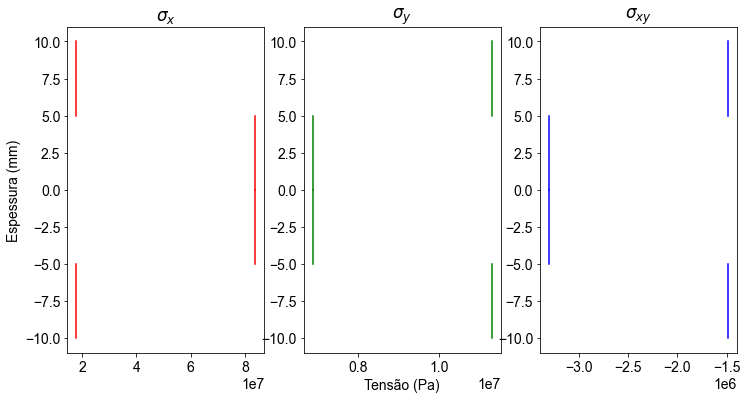

In [86]:
fig, (ax,ax2,ax3) = plt.subplots(1,3, figsize=(12,6))
  
ax.plot([sigma_graph[0,0:n],sigma_graph[0,n:2*n],sigma_graph[0,2*n:3*n]],[z[0,:]*1000,z[1,:]*1000,z[2,:]*1000],'r')
ax2.plot([sigma_graph[1,0:n],sigma_graph[1,n:2*n],sigma_graph[1,2*n:3*n]],[z[0,:]*1000,z[1,:]*1000,z[2,:]*1000],'g')
ax3.plot([sigma_graph[2,0:n],sigma_graph[2,n:2*n],sigma_graph[2,2*n:3*n]],[z[0,:]*1000,z[1,:]*1000,z[2,:]*1000],'b')

ax.set(ylabel='Espessura (mm)', title='$\sigma_x$')
ax2.set(xlabel='Tensão (Pa)', title='$\sigma_y$')
ax3.set(title='$\sigma_{xy}$')